In [13]:
#---------#---------#---------#---------#---------#---------#---------#---------
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm

np.random.seed(321)

### 2.1 Flipping Coins the PyMC Way

- θ ~ Beta(α=1, β=1)
- Υ ~ Binomial(n=1, p=θ)

In [2]:
trials = 4
theta_real = 0.35
data = pz.Binomial(n=1, p=theta_real).rvs(trials)

In [3]:
with pm.Model() as first_mod:
    theta = pm.Beta('theta', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=theta, observed=data)
    idata = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


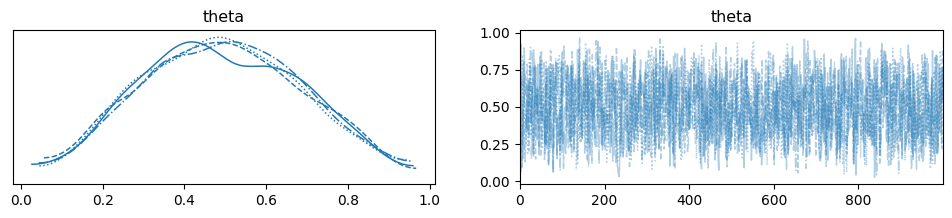

In [4]:
az.plot_trace(idata);

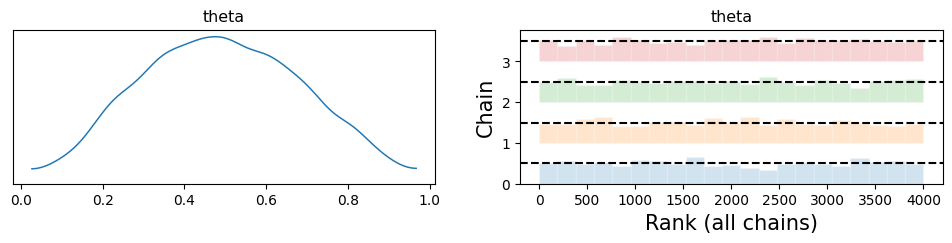

In [5]:
az.plot_trace(idata, kind='rank_bars', combined=True);

In [6]:
az.summary(idata, kind='stats').round(3)

,mean,sd,hdi_3%,hdi_97%
theta,0.491,0.189,0.157,0.838


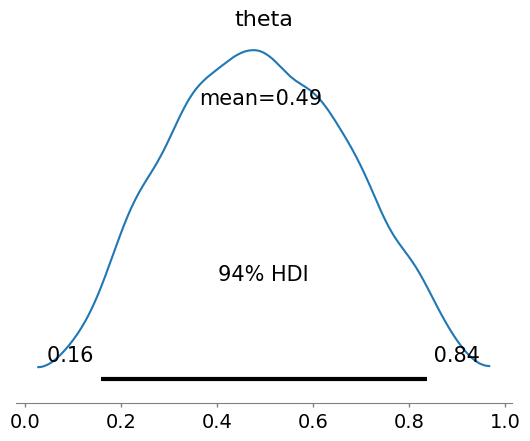

In [7]:
az.plot_posterior(idata);

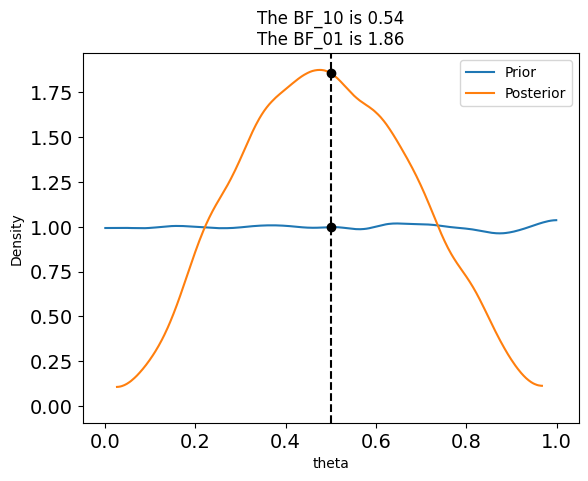

In [8]:
az.plot_bf(
    idata, var_name='theta', prior=np.random.uniform(0, 1, 10_000), ref_val=0.5);

Value of theta is 1.25 (BF_01)x more likely under posterior than prior.
BF_10: value of theta not being 0.5: 0.80x more likely under posterior than prior.

Rule of thumb: BF_01:
- 1 - 3.2: barely worth mentioning
- 3.2 - 10: substantial
- 10 - 100: strong
- 100+: decisive

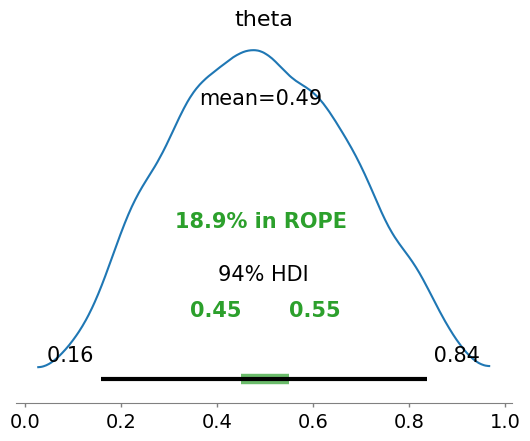

In [9]:
# ROPE: region of practical equivalence
az.plot_posterior(idata, rope=[0.45, 0.55]);

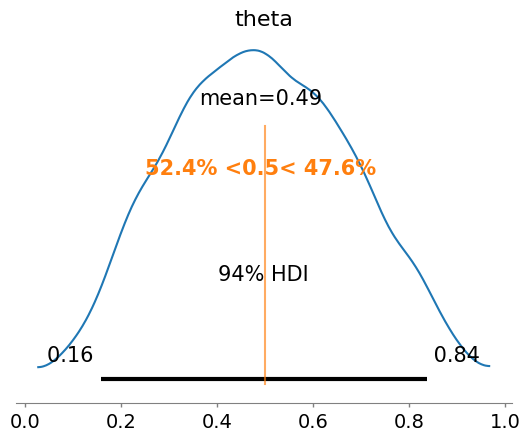

In [10]:
az.plot_posterior(idata, ref_val=0.5);

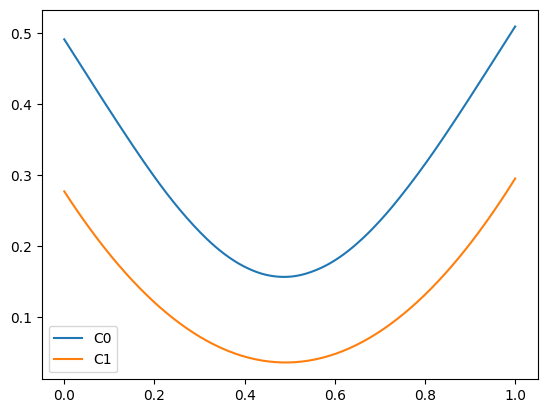

In [16]:
grid = np.linspace(0, 1, 200)
theta_pos = idata.posterior['theta']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean(abs(i - theta_pos)**2) for i in grid]
for lossf, c in zip((lossf_a, lossf_b), ('C0', 'C1')):
    plt.plot(grid, lossf, label=c)
plt.legend();

In [17]:
np.mean(theta_pos), np.median(theta_pos)  # minima of above

(<xarray.DataArray 'theta' ()> Size: 8B
 array(0.49093089),
 np.float64(0.48682349593083063))

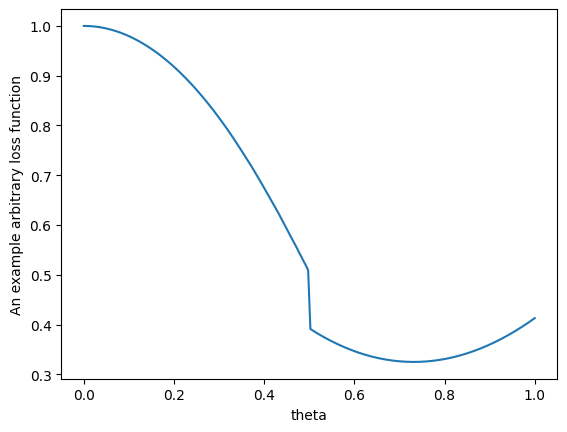

In [20]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1 / np.median(theta_pos / np.abs(i**2 - theta_pos))
    else:
        f = np.mean((i - theta_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)

plt.plot(grid, lossf)
plt.xlabel('theta')
plt.ylabel('An example arbitrary loss function');